In [43]:
import mne
import pandas as pd
import numpy as np
import tqdm as tqdm
import matplotlib.pyplot as plt
import sklearn

**Load Data**

In [44]:
file_path = r'../../Data/ds004196/sub-01/ses-EEG/eeg/sub-01_ses-EEG_task-inner_eeg.bdf'
eeg_data = mne.io.read_raw_bdf(file_path, preload=True)

channels_tsv_path = r'../../Data/ds004196/sub-01/ses-EEG/eeg/sub-01_ses-EEG_task-inner_channels.tsv'
channels_info = pd.read_csv(channels_tsv_path, sep='\t')

events_tsv_path = r'../../Data/ds004196/sub-01/ses-EEG/eeg/sub-01_ses-EEG_task-inner_events.tsv'
events_info = pd.read_csv(events_tsv_path, sep='\t')

montage_path = 'BioSemi64.loc'

Extracting EDF parameters from /Users/omaraguilarjr/GATech/Project-InnerSpeech/Data/ds004196/sub-01/ses-EEG/eeg/sub-01_ses-EEG_task-inner_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696319  =      0.000 ...  1359.998 secs...


**Fix Channels and Set Montage**

In [45]:
def assign_channels(eeg_data, channels_info):
    eeg_data.set_eeg_reference(ref_channels=['Cz'])

    channels_info['name'] = channels_info['name'].replace('T7 (T3)', 'T7')
    channels_info['name'] = channels_info['name'].replace('T8 (T4)', 'T8')
    channels_info['name'] = channels_info['name'].replace('Afz', 'AFz')
    channels_info['name'] = channels_info['name'].replace('Iz (inion)', 'Iz')

    available_channels = set(eeg_data.ch_names).intersection(set(channels_info['name']))
    eeg_data.pick_channels(list(available_channels))
    montage = mne.channels.read_custom_montage(montage_path)
    eeg_data.set_montage(montage, on_missing='ignore')

assign_channels(eeg_data, channels_info)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


**Filter Data**

In [46]:
eeg_data.filter(l_freq=1.0, h_freq=50.0, fir_design='firwin', phase='zero')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


<RawEDF | sub-01_ses-EEG_task-inner_eeg.bdf, 64 x 696320 (1360.0 s), ~340.1 MB, data loaded>

**Run ICA**

In [47]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(eeg_data)
eog_indices, eog_scores = ica.find_bads_eog(eeg_data, ch_name='Fp1')
ica.exclude.extend(eog_indices)
ica.apply(eeg_data)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 31.9s.
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawEDF | sub-01_ses-EEG_task-inner_eeg.bdf, 64 x 696320 (1360.0 s), ~340.1 MB, data loaded>

**Bin Data**

In [48]:
def bin_eeg_data(eeg_data, events_info):
    events_data = events_info.copy()
    events_data['onset'] = events_info['onset'] / 1000
    events_data['duration'] = events_info['duration'] / 1000

    headers = ['label', 'label_type'] + eeg_data.ch_names
    binned_data = []

    for _, event in tqdm.tqdm(events_data.iterrows(), total=len(events_data), desc='EEG Event Binning'):
        if event['trial_type'] in ['wife', 'child', 'father', 'daughter']:
            label_type = 'social'
        elif event['trial_type'] in ['four', 'three', 'ten', 'six']:
            label_type = 'numeric'
        else:
            label_type = 'unknown'

        onset = event['onset']
        duration = event['duration']
        label = event['trial_type']
        
        start_sample = int(onset * eeg_data.info['sfreq'])
        stop_sample = int((onset + duration) * eeg_data.info['sfreq'])

        event_dict = {'label': label, 'label_type': label_type}
        for channel in eeg_data.info['ch_names']:
            event_dict[channel] = eeg_data.get_data(picks=channel, start=start_sample, stop=stop_sample)[0].tolist()
        
        binned_data.append(event_dict)

    binned_df = pd.DataFrame(binned_data, columns=headers)
    return binned_df

binned_df = bin_eeg_data(eeg_data, events_info)

EEG Event Binning: 100%|██████████| 319/319 [00:21<00:00, 14.93it/s]


**Plot Binned Data**

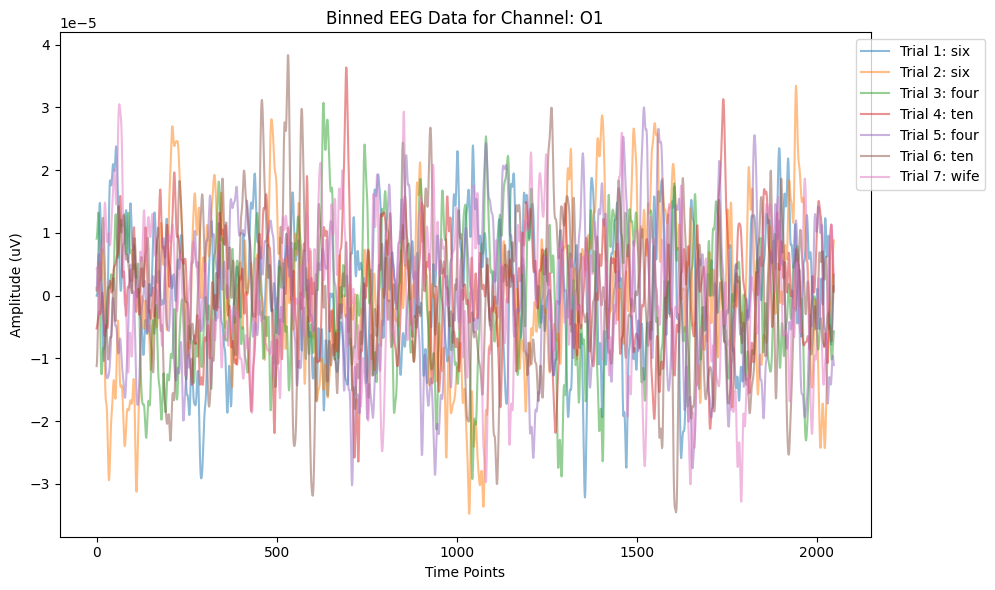

In [49]:
def plot_binned_data(binned_data, channel_name):
    if channel_name not in binned_data.columns:
        print(f"Channel '{channel_name}' not found in binned data.")
        return

    plt.figure(figsize=(10, 6))
    for i, row in binned_data.iterrows():
        plt.plot(row[channel_name], label=f"Trial {i + 1}: {row['label']}", alpha=0.5)
        if i >= 6:
            break

    plt.xlabel('Time Points')
    plt.ylabel('Amplitude (uV)')
    plt.title(f'Binned EEG Data for Channel: {channel_name}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()

plot_binned_data(binned_df, 'O1')

**Save Processed Data**

In [50]:
binned_df.to_csv('../../Data/Processed/sub01_binned.csv', index=False)